In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import scipy.stats as stats
import pickle

# Calculate Coarse-grained Statistics

In [2]:
def stats_3d(var):
    stat_dict = {}
    stat_dict["min"] = np.nanmin(var, axis = (0,2))
    stat_dict["max"] = np.nanmax(var, axis = (0,2))
    stat_dict["mean"] = np.nanmean(var, axis = (0,2))
    stat_dict["median"] = np.nanmedian(var, axis = (0,2))
    stat_dict["p2.5"] = np.nanpercentile(var, 2.5, axis = (0,2))
    stat_dict["p5"] = np.nanpercentile(var, 5, axis = (0,2))
    stat_dict["p25"] = np.nanpercentile(var, 25, axis = (0,2))
    stat_dict["p75"] = np.nanpercentile(var, 75, axis = (0,2))
    stat_dict["p95"] = np.nanpercentile(var, 95, axis = (0,2))
    stat_dict["p97.5"] = np.nanpercentile(var, 97.5, axis = (0,2))
    return stat_dict



In [4]:
base = "/p/project1/icon-a-ml/hafner1/cloudy_radiation/data/"
months = ["november", "january", "april"]
test_data = xr.open_mfdataset([f"{base}{m}/test_LW.zarr" for m in months], engine="zarr")

In [13]:
statistics = {}

for v in test_data.variables:
    stat_dict = {}
    # statistics: min, mean, max, std, p2.5, p5, p95, p97.5, median
    print(v)
    if v in ["height", "height_2", "time", "height_bnds", "lev", "cell"]:
        continue
    var = test_data[v]
    s = var.shape
    #if v in ["rsd", "rsu", "q_rsw", "tend_ta_rsw", "cosmu0_rt", "rsucs", "rsdcs", 
    #         "rsds", "rsut", "rsus", "rsdscs", "rsutcs", "rsuscs", "extra_2d_albedo", 
    #         "rpds_dir", "rpds_dif", "rnds_dir", "rnds_dif", "rvds_dir", "rvds_dif",
    #         "albnirdir", "albnirdif", "albvisdir", "albvisdif", "rnus", "rvus", "rpus",]:
    #    var = var.where(test_data["cosmu0"].compute()>0, drop=True)
    if len(s) == 2:
        stat_dict["min"] = var.min().values
        stat_dict["max"] = var.max().values
        stat_dict["mean"] = var.mean().values
        stat_dict["median"] = np.nanmedian(var)
        stat_dict["p2.5"] = np.nanpercentile(var, 2.5)
        stat_dict["p5"] = np.nanpercentile(var, 5)
        stat_dict["p25"] = np.nanpercentile(var, 25)
        stat_dict["p75"] = np.nanpercentile(var, 75)
        stat_dict["p95"] = np.nanpercentile(var, 95)
        stat_dict["p97.5"] = np.nanpercentile(var, 97.5)
    elif len(s) == 3:
        stat_dict["min"] = np.nanmin(var, axis = (0,2))
        stat_dict["max"] = np.nanmax(var, axis = (0,2))
        stat_dict["mean"] = np.nanmean(var, axis = (0,2))
        stat_dict["median"] = np.nanmedian(var, axis = (0,2))
        stat_dict["p2.5"] = np.nanpercentile(var, 2.5, axis = (0,2))
        stat_dict["p5"] = np.nanpercentile(var, 5, axis = (0,2))
        stat_dict["p25"] = np.nanpercentile(var, 25, axis = (0,2))
        stat_dict["p75"] = np.nanpercentile(var, 75, axis = (0,2))
        stat_dict["p95"] = np.nanpercentile(var, 95, axis = (0,2))
        stat_dict["p97.5"] = np.nanpercentile(var, 97.5, axis = (0,2))
        
    else:
        raise ValueError(f"Don't know this type of variable: {v}. Unexpected shape: {s}")
    statistics[v] = stat_dict 
        

cell_idx
cl
clt
cvair
dzghalf
extra_2d_albedo
extra_2d_iwp
extra_2d_lwp
extra_2d_pr
extra_2d_prw
extra_3d_cli
extra_3d_clw
extra_3d_hus
extra_3d_qs
extra_3d_ta
o3
pr
pr_grpl
pr_ice
pr_rain
pr_snow
pres_layer
pres_level
ps
rho
rld
rldcs
rlds_rld
rlu
rlucs
rlut
temp_level
tend_ta_rlw
tend_ta_rlw_cs
ts
ts_rad
zfull
zhalf
cell
height
height_2
time


In [5]:
# add cre heating
var = test_data["tend_ta_rlw"].values - test_data["tend_ta_rlw_cs"].values
statistics["tend_ta_rlw_cre"] = stats_3d(var)


In [6]:
# correct heating rates 
height_lower_layer = test_data["zhalf"][:,1:].values  # height lower half level
height_upper_layer = test_data["zhalf"][:,:-1].values  # height upper half level
grid_sphere_radius = 6.371229e6
radial_distance_lifc = grid_sphere_radius + height_lower_layer
radial_distance_uifc = grid_sphere_radius + height_upper_layer

deepatmo_vol_mc = ( radial_distance_lifc**2 + 
                   radial_distance_lifc * radial_distance_uifc  + 
                   radial_distance_uifc**2 ) / ( 3 * grid_sphere_radius**2 )

vweigths = np.load("/p/project1/icon-a-ml/hafner1/cloudy_radiation/preprocessing/weights_vert_integral_on_cg.npy")
row_idx = np.arange(vweigths.shape[0])[None, :, None]
vw = vweigths[row_idx,test_data["cell_idx"].values.astype("int")[:,None,:]] # broadcast weigths to test_data shaope
mair = test_data["rho"]*(height_upper_layer -height_lower_layer)*deepatmo_vol_mc
cvair = test_data["cvair"].values*vw
cv = cvair/mair
cpd=1004.64
cpv=1869.46
g=9.80665
qv=test_data["extra_3d_hus"]
cp = (1-qv)*cpd+qv*cpv
correction = (cv/cp).values

statistics["corrected_tend_ta_rlw"] = stats_3d(correction*test_data["tend_ta_rlw"].values)
statistics["corrected_tend_ta_rlw_cs"] = stats_3d(correction*test_data["tend_ta_rlw_cs"].values)
statistics["corrected_tend_ta_rlw_cre"] = stats_3d(correction*test_data["tend_ta_rlw"].values-correction*test_data["tend_ta_rlw_cs"].values)

In [7]:
base = "/p/project1/icon-a-ml/hafner1/cloudy_radiation/data/"
months = ["november", "january", "april"]
test_data = xr.open_mfdataset([f"{base}{m}/test_SW.zarr" for m in months], engine="zarr")

In [16]:
for v in ["albnirdif", "albnirdir", "albvisdif", "albvisdir","cosmu0", "cosmu0_rt", 
          "extra_2d_albedo", "rnds_dif", "rnds_dir", "rpds_dif","rpds_dir", "rsds",
          "rsut", "rvds_dif", "rvds_dir", "tend_ta_rsw", "tend_ta_rsw_cs", "toa",
         "rsu", "rsucs", "rsd", "rsdcs"]:
    stat_dict = {}
    # statistics: min, mean, max, std, p2.5, p5, p95, p97.5, median
    print(v)
    if v in ["height", "height_2", "time", "height_bnds", "lev", "cell"]:
        continue
    var = test_data[v]
    s = var.shape
    #if v in ["rsd", "rsu", "q_rsw", "tend_ta_rsw", "cosmu0_rt", "rsucs", "rsdcs", 
    #         "rsds", "rsut", "rsus", "rsdscs", "rsutcs", "rsuscs", "extra_2d_albedo", 
    #         "rpds_dir", "rpds_dif", "rnds_dir", "rnds_dif", "rvds_dir", "rvds_dif",
    #         "albnirdir", "albnirdif", "albvisdir", "albvisdif", "rnus", "rvus", "rpus",]:
    #    var = var.where(test_data["cosmu0"].compute()>0, drop=True)
    if len(s) == 2:
        stat_dict["min"] = var.min().values
        stat_dict["max"] = var.max().values
        stat_dict["mean"] = var.mean().values
        stat_dict["median"] = np.nanmedian(var)
        stat_dict["p2.5"] = np.nanpercentile(var, 2.5)
        stat_dict["p5"] = np.nanpercentile(var, 5)
        stat_dict["p25"] = np.nanpercentile(var, 25)
        stat_dict["p75"] = np.nanpercentile(var, 75)
        stat_dict["p95"] = np.nanpercentile(var, 95)
        stat_dict["p97.5"] = np.nanpercentile(var, 97.5)
    elif len(s) == 3:
        stat_dict["min"] = np.nanmin(var, axis = (0,2))
        stat_dict["max"] = np.nanmax(var, axis = (0,2))
        stat_dict["mean"] = np.nanmean(var, axis = (0,2))
        stat_dict["median"] = np.nanmedian(var, axis = (0,2))
        stat_dict["p2.5"] = np.nanpercentile(var, 2.5, axis = (0,2))
        stat_dict["p5"] = np.nanpercentile(var, 5, axis = (0,2))
        stat_dict["p25"] = np.nanpercentile(var, 25, axis = (0,2))
        stat_dict["p75"] = np.nanpercentile(var, 75, axis = (0,2))
        stat_dict["p95"] = np.nanpercentile(var, 95, axis = (0,2))
        stat_dict["p97.5"] = np.nanpercentile(var, 97.5, axis = (0,2))
        
    else:
        raise ValueError(f"Don't know this type of variable: {v}. Unexpected shape: {s}")
    statistics[v] = stat_dict 

albnirdif
albnirdir
albvisdif
albvisdir
cosmu0
cosmu0_rt
extra_2d_albedo
rnds_dif
rnds_dir
rpds_dif
rpds_dir
rsds
rsut
rvds_dif
rvds_dir
tend_ta_rsw
tend_ta_rsw_cs
toa
rsu
rsucs
rsd
rsdcs


In [8]:
# add cre heating
var = test_data["tend_ta_rsw"].values - test_data["tend_ta_rsw_cs"].values
statistics["tend_ta_rsw_cre"] = stats_3d(var)



In [9]:
# correct heating rates 
height_lower_layer = test_data["zhalf"][:,1:].values  # height lower half level
height_upper_layer = test_data["zhalf"][:,:-1].values  # height upper half level
grid_sphere_radius = 6.371229e6
radial_distance_lifc = grid_sphere_radius + height_lower_layer
radial_distance_uifc = grid_sphere_radius + height_upper_layer

deepatmo_vol_mc = ( radial_distance_lifc**2 + 
                   radial_distance_lifc * radial_distance_uifc  + 
                   radial_distance_uifc**2 ) / ( 3 * grid_sphere_radius**2 )

vweigths = np.load("/p/project1/icon-a-ml/hafner1/cloudy_radiation/preprocessing/weights_vert_integral_on_cg.npy")
row_idx = np.arange(vweigths.shape[0])[None, :, None]
vw = vweigths[row_idx,test_data["cell_idx"].values.astype("int")[:,None,:]] # broadcast weigths to test_data shaope
mair = test_data["rho"]*(height_upper_layer -height_lower_layer)*deepatmo_vol_mc
cvair = test_data["cvair"].values*vw
cv = cvair/mair
cpd=1004.64
cpv=1869.46
g=9.80665
qv=test_data["extra_3d_hus"]
cp = (1-qv)*cpd+qv*cpv
correction = (cv/cp).values

statistics["corrected_tend_ta_rsw"] = stats_3d(correction*test_data["tend_ta_rsw"].values)
statistics["corrected_tend_ta_rsw_cs"] = stats_3d(correction*test_data["tend_ta_rsw_cs"].values)
statistics["corrected_tend_ta_rsw_cre"] = stats_3d(correction*test_data["tend_ta_rsw"].values-correction*test_data["tend_ta_rsw_cs"].values)

In [10]:
with open("statistics_coarse_grained_nja.pickle", 'wb') as handle:
    pickle.dump(statistics, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load and plot statistics

In [3]:
with open("/p/project1/icon-a-ml/hafner1/cloudy_radiation/statistics_coarse_grained_nja.pickle", 'rb') as handle:
    statistics = pickle.load(handle)

In [23]:
with open("/p/project1/icon-a-ml/hafner1/cloudy_radiation/statistics_2004_mig_cs.pickle", 'rb') as handle:
    statistics_cs = pickle.load(handle)
#with open("/p/project1/icon-a-ml/hafner1/cloudy_radiation/statistics_2004.pickle", 'rb') as handle:
#    statistics_cs = pickle.load(handle)


/tmp/ipykernel_2700492/1282311509.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  statistics_cs = pickle.load(handle)


In [6]:
statistics_cs.keys()

dict_keys(['daylght_frc_rt', 'ptp', 'vas', 'tauv', 'tauu', 'evspsbl', 'hfss', 'hfls', 'prls', 'prlr', 'psl', 'ps', 'orog', 'rtype', 'sftgif', 'sftlf', 'sit', 'sic', 'ts_rad', 'ts', 'rluscs', 'rlus', 'rsuscs', 'rsus', 'rldscs', 'rlds', 'rsdscs', 'rsds', 'rlutcs', 'rsutcs', 'albnirdif', 'albvisdif', 'albnirdir', 'albvisdir', 'clt', 'daylght_frc', 'emissivity', 'pr', 'rnus', 'rpus', 'rvus', 'rnds_dif', 'rpds_dif', 'rvds_dif', 'rnds_dir', 'rpds_dir', 'rvds_dir', 'rlut', 'rsut', 'extra_2d_albedo', 'extra_2d_clivi', 'extra_2d_cllvi', 'extra_2d_prw', 'cosmu0_rt', 'cosmu0', 'ta', 'hus', 'clw', 'cli', 'qconv', 'tend_ta_rsw', 'tend_ta_rlw', 'tend_ta_rad', 'acdnc', 'cl', 'mdry_phy', 'wa', 'va', 'ua', 'rho', 'rsucs', 'rsdcs', 'rlucs', 'rldcs', 'o3', 'phalf', 'q_rlw', 'q_rsw', 'rlu', 'rld', 'rsu', 'rsd', 'extra_3d_cl', 'extra_3d_clw', 'extra_3d_cli', 'extra_3d_ta', 'extra_3d_pfull', 'extra_3d_hus', 'tend_ta_rsw_cs', 'tend_ta_rsw_cre', 'tend_ta_rlw_cs', 'tend_ta_rlw_cre'])

In [5]:
zh_lr_path = "/p/project1/icon-a-ml/hafner1/org_radiation/preprocessing/atm_amip_R2B5_vgrid_ml.nc"
vgrid = xr.open_mfdataset(zh_lr_path)
height = np.mean(vgrid["zfull"].values, axis=-1)/1000 # in km
zhalf = np.mean(vgrid["zhalf"].values, axis=-1)/1000 # in km

In [21]:
label_translate = {"extra_3d_hus": "$q_v$ [g/kg]",
                  "extra_3d_cli": "$q_i$ [g/kg]",
                  "extra_3d_clw": "$q_l$ [g/kg]",
                  "extra_3d_qs": "$q_s$ [g/kg]",
                  "rho": "$\\rho$ [$kg/m^3$]",
                  "o3": "O3 [mol/mol]",
                  "extra_3d_ta": "T [K]",
                  "extra_2d_albedo": "$\\alpha$",
                  "toa": "$F_{in,TOA}$ [$W/m^2$]",
                  "cl": "cloud fr. [%]",
                  "ts_rad": "$T_{S,rad}$ [K]",
                  "ts": "$T_{S}$ [K]",
                  "albnirdir": "$\\alpha_{NIR, dir}$",
                  "albnirdif": "$\\alpha_{NIR, dif}$",
                  "albvisdir": "$\\alpha_{vis, dir}$",
                  "albvisdif": "$\\alpha_{vis, dif}$",
                  "tend_ta_rsw": "$\partial T_{SW} / \partial t $ [K/d]",
                  "tend_ta_rlw": "$\partial T_{LW} / \partial t $ [K/d]",
                  "tend_ta_rsw_cs": "$\partial T_{SW, clear} / \partial t $ [K/d]",
                  "tend_ta_rlw_cs": "$\partial T_{LW, clear} / \partial t $ [K/d]",
                  "tend_ta_rsw_cre": "$\partial T_{SW, cri} / \partial t $ [K/d]",
                  "tend_ta_rlw_cre": "$\partial T_{LW, cri} / \partial t $ [K/d]",
                  "rsds": "$F_{\downarrow,SW,surf}$ [$W/m^2$]",
                   "rnds_dir":  "$F_{\downarrow, surf, NIR, dir}$ [$W/m^2$]",
                   "rnds_dif":  "$F_{\downarrow, surf, NIR, dif}$ [$W/m^2$]",
                   "rvds_dir":  "$F_{\downarrow,surf,vis,dir}$ [$W/m^2$]",
                   "rvds_dif": "$F_{\downarrow,surf,vis,dif}$ [$W/m^2$]",
                   "rpds_dir":  "$F_{\downarrow,surf,PAR,dir}$ [$W/m^2$]",
                   "rpds_dif":  "$F_{\downarrow,surf,PAR,dif}$ [$W/m^2$]",
                   "rsut": "$F_{\\uparrow,SW,TOA}$ [$W/m^2$]",
                   "rlds":  "$F_{\downarrow,LW,surf}$ [$W/m^2$]",
                   "rlut": "$F_{\\uparrow,LW,TOA}$ [$W/m^2$]",
                   "rsucs": "$F_{\\uparrow,SW,CS}$ [$W/m^2$]",
                   "rsdcs": "$F_{\\downarrow,SW,CS}$ [$W/m^2$]",
                   "rldcs":  "$F_{\downarrow,LW,CS}$ [$W/m^2$]",
                   "rlucs": "$F_{\\uparrow,LW,CS}$ [$W/m^2$]",
                   "rsu": "$F_{\\uparrow,SW}$ [$W/m^2$]",
                   "rsd": "$F_{\\downarrow,SW}$ [$W/m^2$]",
                   "rld":  "$F_{\downarrow,LW}$ [$W/m^2$]",
                   "rlu": "$F_{\\uparrow,LW}$ [$W/m^2$]",
                   "clt": "[%]"  ,
                   "pr": "precip flux",
                   "tauv": "v-momentum flux",
                   "extra_2d_clivi": "clivi",
                   "extra_2d_cllvi": "cllvi",
                   "extra_2d_prw": "prw",
                   "cosmu0": "$cos(\mu)$",
                   "cosmu0_rt": "$cos(\mu)$",
                   "ps": "Surface pressure [Pa]"
                  }
title_translate = {"extra_3d_hus": "Specific Humidity",
                  "extra_3d_cli": "Cloud Ice",
                  "extra_3d_clw": "Cloud Water",
                  "extra_3d_qs": "Snow",
                  "rho": "Density",
                  "o3": "Ozone",
                  "extra_3d_ta": "Temperature",
                  "extra_2d_albedo": "Albedo",
                  "toa": "Incoming Flux at TOA",
                  "cl": "Cloud Area Fraction",
                  "ts_rad": "Surface Temperature at rad.",
                  "ts": "Surface Temperature",
                  "albnirdir": "$\\alpha_{NIR, dir}$",
                  "albnirdif": "$\\alpha_{NIR, dif}$",
                  "albvisdir": "$\\alpha_{vis, dir}$",
                  "albvisdif": "$\\alpha_{vis, dif}$",
                  "tend_ta_rsw": "SW HR - All Sky",
                  "tend_ta_rlw": "LW HR - All Sky",
                  "tend_ta_rsw_cs": "SW HR - Clear Sky",
                  "tend_ta_rlw_cs": "LW HR - Clear Sky",
                  "tend_ta_rsw_cre": "SW HR - Cloud Radiative Impact",
                  "tend_ta_rlw_cre": "LW HR - Cloud Radiative Impact",
                  "rsds": "SW Downward Flux at the Surface",
                   "rnds_dir":  "$F_{\downarrow, surf, NIR, dir}$",
                   "rnds_dif":  "$F_{\downarrow, surf, NIR, dif}$",
                   "rvds_dir":  "$F_{\downarrow,surf,vis,dir}$",
                   "rvds_dif": "$F_{\downarrow,surf,vis,dif}$",
                   "rpds_dir":  "$F_{\downarrow,surf,PAR,dir}$",
                   "rpds_dif":  "$F_{\downarrow,surf,PAR,dif}$",
                   "rsut": "SW Upward Flux at TOA",
                   "rlds":  "LW Downward Flux at the Surface",
                   "rlut": "LW Upward Flux at TOA",
                   "rsucs": "$F_{\\uparrow,SW,CS}$ [$W/m^2$]",
                   "rsdcs": "$F_{\\downarrow,SW,CS}$ [$W/m^2$]",
                   "rldcs":  "$F_{\downarrow,LW,CS}$ [$W/m^2$]",
                   "rlucs": "$F_{\\uparrow,LW,CS}$ [$W/m^2$]",
                   "rsu": "$F_{\\uparrow,SW}$ [$W/m^2$]",
                   "rsd": "$F_{\\downarrow,SW}$ [$W/m^2$]",
                   "rld":  "$F_{\downarrow,LW}$ [$W/m^2$]",
                   "rlu": "$F_{\\uparrow,LW}$ [$W/m^2$]",
                   "clt": "Total Cloud Cover"  ,
                   "pr": "precip flux",
                   "tauv": "v-momentum flux",
                   "extra_2d_clivi": "clivi",
                   "extra_2d_cllvi": "cllvi",
                   "extra_2d_prw": "prw",
                   "cosmu0": "Cosine of Solar Zenith Angle",
                   "cosmu0_rt": "Cosine of Solar Zenith Angle at rad. ",
                   "ps": "Surface pressure"
                  }

In [9]:
statistics.keys()

dict_keys(['cell_idx', 'cl', 'clt', 'cvair', 'dzghalf', 'extra_2d_albedo', 'extra_2d_iwp', 'extra_2d_lwp', 'extra_2d_pr', 'extra_2d_prw', 'extra_3d_cli', 'extra_3d_clw', 'extra_3d_hus', 'extra_3d_qs', 'extra_3d_ta', 'o3', 'pr', 'pr_grpl', 'pr_ice', 'pr_rain', 'pr_snow', 'pres_layer', 'pres_level', 'ps', 'rho', 'rld', 'rldcs', 'rlds_rld', 'rlu', 'rlucs', 'rlut', 'temp_level', 'tend_ta_rlw', 'tend_ta_rlw_cs', 'ts', 'ts_rad', 'zfull', 'zhalf', 'tend_ta_rlw_cre', 'albnirdif', 'albnirdir', 'albvisdif', 'albvisdir', 'cosmu0', 'cosmu0_rt', 'rnds_dif', 'rnds_dir', 'rpds_dif', 'rpds_dir', 'rsds', 'rsut', 'rvds_dif', 'rvds_dir', 'tend_ta_rsw', 'tend_ta_rsw_cs', 'toa', 'rsu', 'rsucs', 'rsd', 'rsdcs', 'tend_ta_rsw_cre'])

ps


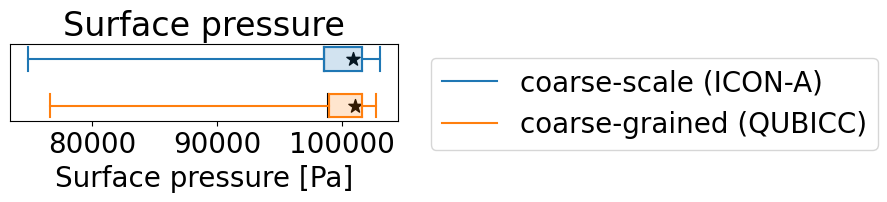

ts_rad


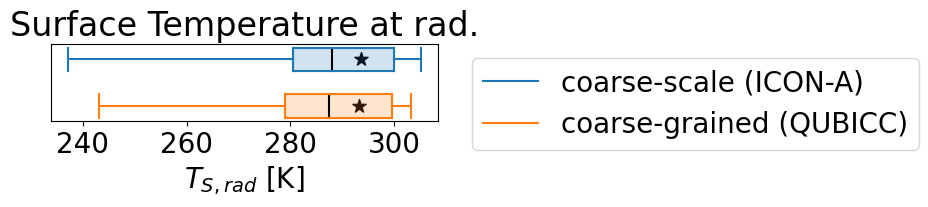

ts


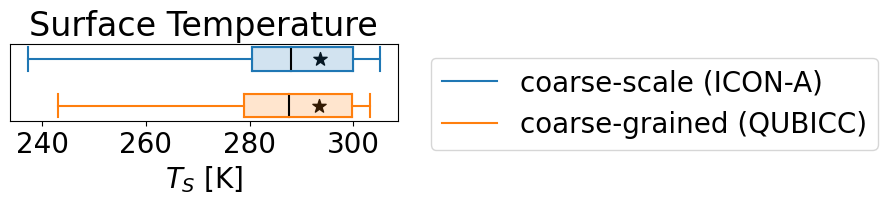

rlds


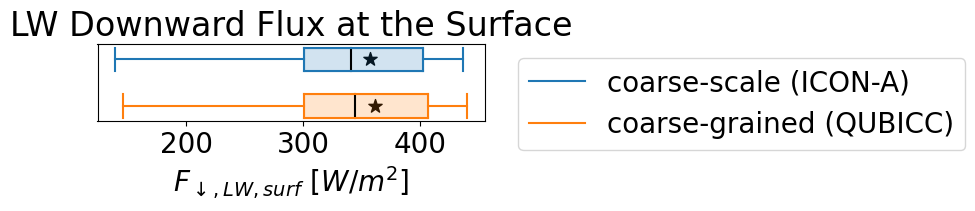

rsds


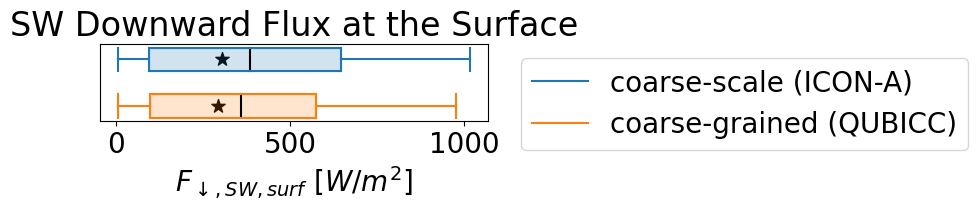

albnirdif


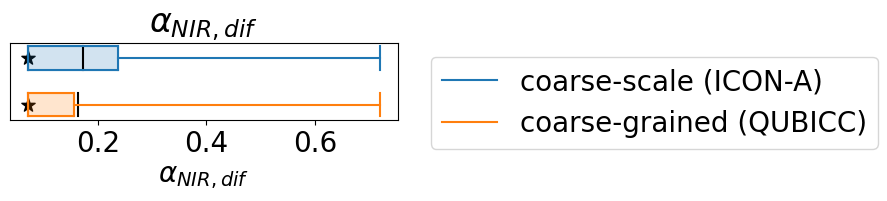

albvisdif


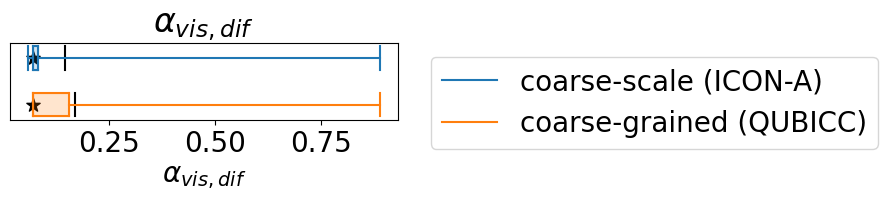

albnirdir


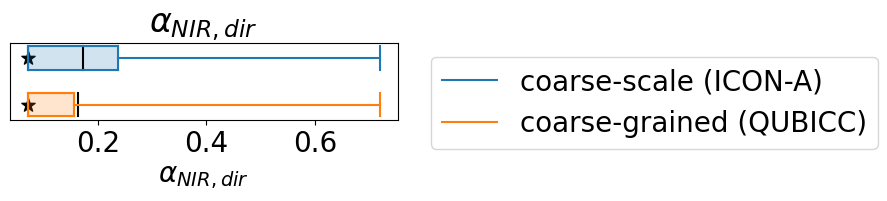

albvisdir


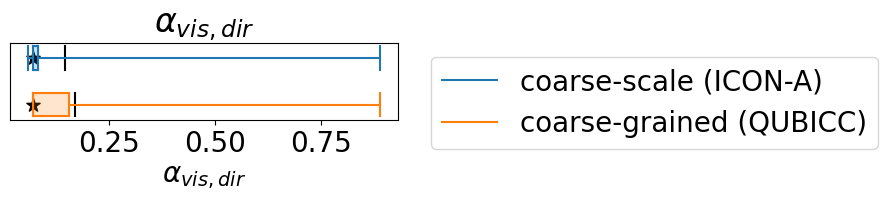

clt


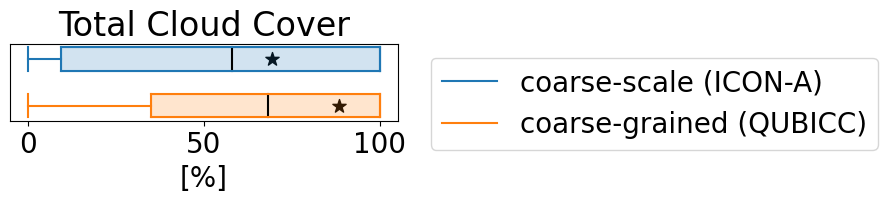

pr


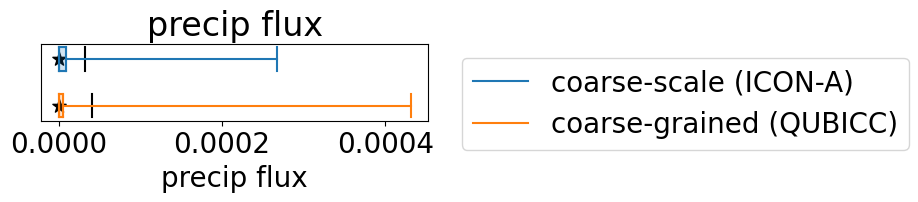

rnds_dif


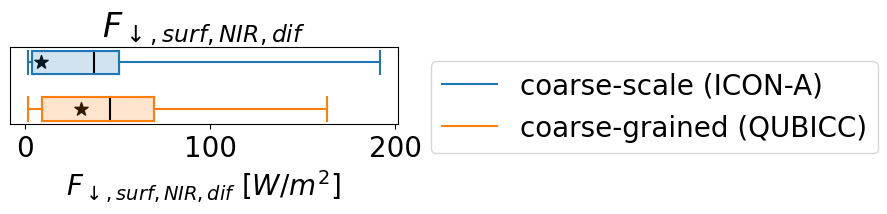

rpds_dif


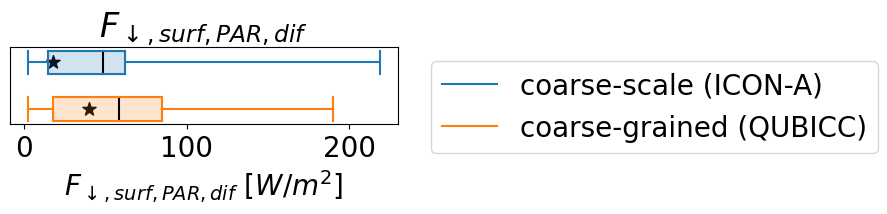

rvds_dif


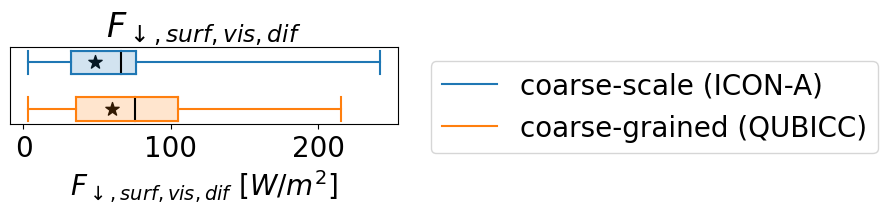

rnds_dir


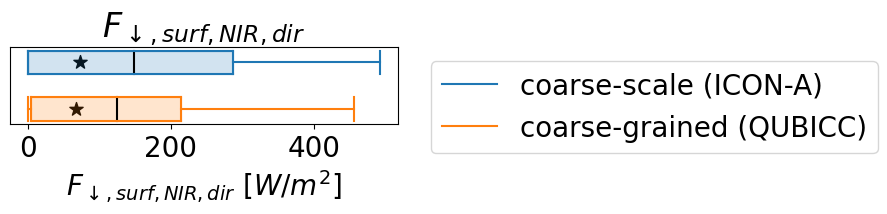

rpds_dir


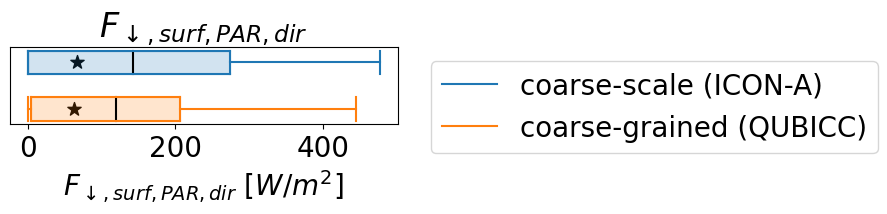

rvds_dir


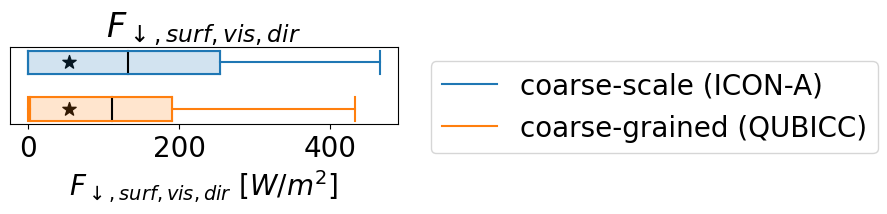

rlut


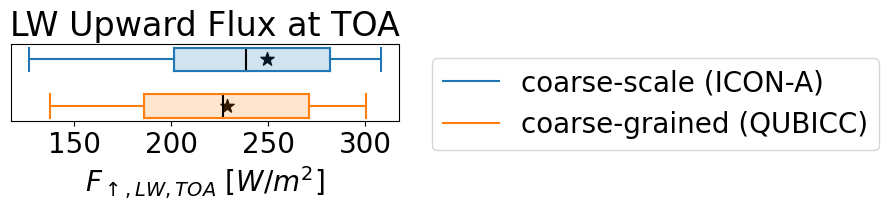

rsut


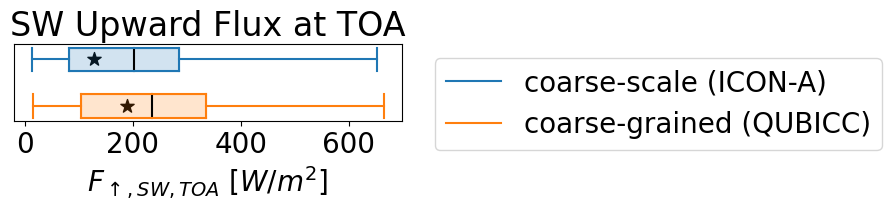

extra_2d_albedo


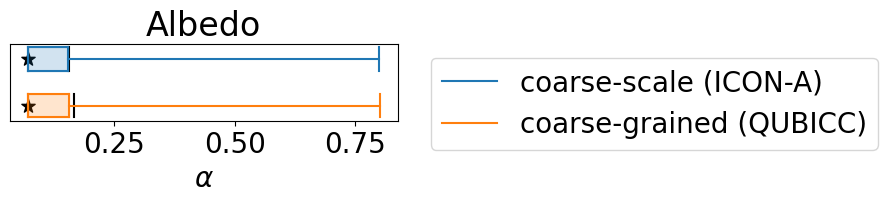

extra_2d_prw


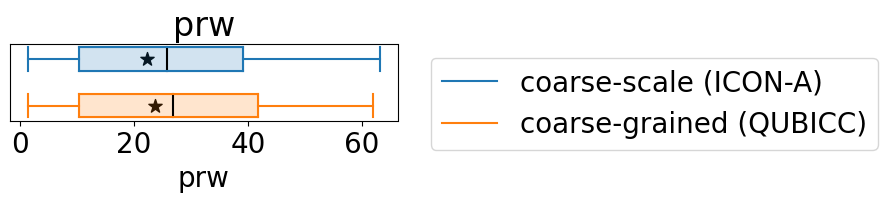

cosmu0_rt


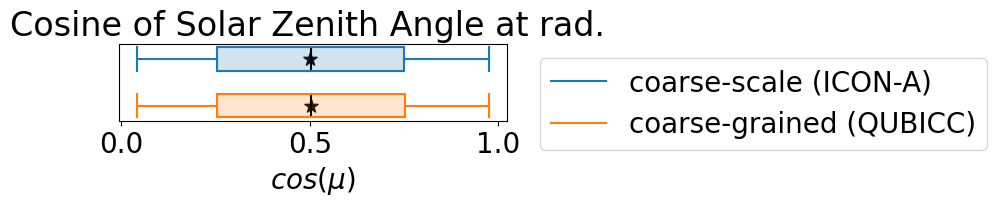

cosmu0


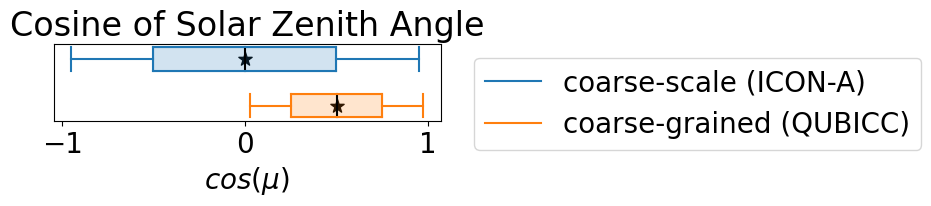

tend_ta_rsw
tend_ta_rlw
cl
rho
rsucs
rsdcs
rlucs
rldcs
o3
rlu
rld
rsu
rsd
extra_3d_clw
extra_3d_cli
extra_3d_ta
extra_3d_hus
tend_ta_rsw_cs
tend_ta_rsw_cre
tend_ta_rlw_cs
tend_ta_rlw_cre


In [24]:
import matplotlib as mpl
mpl.rcParams['font.size'] = '20'

for v in statistics_cs.keys():
    if v in statistics.keys():
        sd1 = statistics_cs[v]
        sd2 = statistics[v]
    elif v == "rlds":
        sd1 = statistics_cs[v]
        sd2 = statistics["rlds_rld"]
    else:
        continue
    print(v)
    if v in ["ptp"]:
        continue
    if "tend_ta" in v:
        f = 86400
    elif v in ["extra_3d_hus", "extra_3d_cli", "extra_3d_clw"]:
        f=1000
    elif "cl" in v:
        f=100
    else:
        f=1
    c_cs = "C0"
    c_cg = "C1"
    min_stat = "p2.5"
    max_stat = "p97.5"
    
    if sd1[min_stat].shape == (47,):
        continue
        plt.title(title_translate[v])
        plt.fill_betweenx(height, f*sd1[min_stat], f*sd1[max_stat], alpha=0.2, color = c_cs)
        plt.plot(f*sd1["mean"], height, label="coarse scale", color = c_cs)
        plt.fill_betweenx(height, f*sd2[min_stat], f*sd2[max_stat], alpha=0.2, color = c_cg)
        plt.plot(f*sd2["mean"], height, label = "coarse grained", color = c_cg)
        plt.ylabel("Height [km]")
        plt.xlabel(label_translate[v])
        plt.legend(bbox_to_anchor=(2, 1))
        if v in ["extra_3d_hus", "extra_3d_cli", "extra_3d_clw", "rho","cl"]:
            #plt.xscale("log")
            #plt.yscale("log")
            plt.legend(bbox_to_anchor=(2, 1))
            plt.ylim((0, 20))
            plt.xlim(1e-7, np.maximum(np.max(sd1[max_stat]),np.max(sd2[max_stat]))*1.05*f)
            if v =="cl":
                plt.xlim((0,100))
        #if v in "tend_ta" in v:
        #    plt.yscale("log")
        #plt.ylim((np.min(height), np.max(height)))
        plt.grid()
        plt.show()
        plt.close()
    elif sd1[min_stat].shape == (48,):
        continue
        plt.title(title_translate[v])
        plt.fill_betweenx(zhalf, f*sd1[min_stat], f*sd1[max_stat], alpha=0.2, color = c_cs)
        plt.plot(f*sd1["mean"], zhalf, label = "coarse scale", color = c_cs)
        plt.fill_betweenx(zhalf, f*sd2[min_stat], f*sd2[max_stat], alpha=0.2, color = c_cg)
        plt.plot(f*sd2["mean"], zhalf, label = "coarse grained", color = c_cg)
        plt.ylabel("Height [km]")
        plt.legend(bbox_to_anchor=(2, 1))
        plt.xlabel(label_translate[v])
        plt.grid()
        plt.ylim((np.min(zhalf), np.max(zhalf)))
        plt.show()
        plt.close()
    else:
        # Create the boxplot
        plt.figure(figsize=(5, 1))
        plt.title(title_translate[v])
        plt.scatter(f*sd1["median"], 1, marker="*", s=100, c="k")  # median
        plt.plot([f*sd1["mean"], f*sd1["mean"]], [0.5, 1.5], 'k-')  # mean
        plt.plot([f*sd1["p2.5"], f*sd1[min_stat]], [0.5, 1.5], color = c_cs, label= "coarse-scale (ICON-A)")  # min
        plt.plot([f*sd1[max_stat], f*sd1[max_stat]],[0.5, 1.5], color = c_cs)  # max
        plt.plot([f*sd1["p25"], f*sd1["p25"]],[0.5, 1.5], color = c_cs)  # p25
        plt.plot([f*sd1["p75"], f*sd1["p75"]],[0.5, 1.5], color = c_cs)  # p75
        plt.plot([f*sd1[min_stat], f*sd1["p25"]], [1,1], color = c_cs)  # vertical line
        plt.plot([f*sd1["p75"], f*sd1[max_stat]],[1, 1], color = c_cs)  # vertical line
        plt.plot([f*sd1["p25"], f*sd1["p75"]],[0.5, 0.5], color = c_cs)  # vertical line
        plt.plot([f*sd1["p25"], f*sd1["p75"]],[1.5, 1.5], color = c_cs)  # vertical line
        plt.fill_betweenx([0.5,1.5], [f*sd1["p25"],f*sd1["p25"]], [f*sd1["p75"],f*sd1["p75"]], color=c_cs, alpha=0.2)
        
        # Create the boxplot
        plt.scatter(f*sd2["median"], 3, marker="*", s=100, c="k")  # median
        plt.plot([f*sd2["mean"], f*sd2["mean"]], [2.5, 3.5], 'k-')  # mean
        plt.plot([f*sd2[min_stat], f*sd2[min_stat]], [2.5, 3.5], color = c_cg, label="coarse-grained (QUBICC)")  # min
        plt.plot([f*sd2[max_stat], f*sd2[max_stat]],[2.5, 3.5], color = c_cg)  # max
        plt.plot([f*sd2["p25"], f*sd2["p25"]],[2.5, 3.5], color = c_cg)  # p25
        plt.plot([f*sd2["p75"], f*sd2["p75"]],[2.5, 3.5], color = c_cg)  # p75
        plt.plot([f*sd2[min_stat], f*sd2["p25"]], [3,3], color = c_cg)  # vertical line
        plt.plot([f*sd2["p75"], f*sd2[max_stat]],[3, 3], color = c_cg)  # vertical line
        plt.plot([f*sd2["p25"], f*sd2["p75"]],[2.5, 2.5], color = c_cg)  # vertical line
        plt.plot([f*sd2["p25"], f*sd2["p75"]],[3.5, 3.5], color = c_cg)  # vertical line
        plt.fill_betweenx([2.5,3.5], [f*sd2["p25"],f*sd2["p25"]], [f*sd2["p75"],f*sd2["p75"]], color=c_cg, alpha=0.2)
        plt.xlabel(label_translate[v])
        plt.gca().invert_yaxis()
        plt.legend(bbox_to_anchor=(1.05, 1))

        if v in ["extra_2d_clivi", "extra_2d_cllvi"]:
            plt.xscale("log")
            plt.xlim(1e-7, sd2[max_stat]*1.05)

        plt.yticks([],[])
        
        # Show the plot
        plt.show()
        plt.close()

In [16]:
import matplotlib as mpl
mpl.rcParams['font.size'] = '12'

def plot_3d_full_level(sd1, sd2, v="", height_label=False, ax=None):
    if "tend_ta" in v:
        f = 86400
    elif v in ["extra_3d_hus", "extra_3d_cli", "extra_3d_clw", "extra_3d_qs"]:
        f=1000
    elif "cl" in v:
        f=100
    else:
        f=1
    c_cs = "C0"
    c_cg = "C1"
    min_stat = "p2.5"
    max_stat = "p97.5"
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.set_title(title_translate[v])
    if not (sd1 == None):
        ax.fill_betweenx(height, f*sd1[min_stat], f*sd1[max_stat], alpha=0.2, color = c_cs)
        ax.plot(f*sd1["mean"], height, label="coarse scale", color = c_cs)
        print(v, "mean diff: ", np.mean(f*(sd1["mean"]-sd2["mean"])), 
              "abs mean diff: ", np.mean(f*np.abs(sd1["mean"]-sd2["mean"])), 
              "min diff: ", np.min(f*np.abs(sd1["mean"]-sd2["mean"])), 
              "max diff: ", np.max(f*np.abs(sd1["mean"]-sd2["mean"]))
             )
        n = 46
        print(f"bottom {n} levels ", height[-n], v, 
              "mean diff: ", np.mean(f*(sd1["mean"]-sd2["mean"])[-n:]), 
              "abs mean diff: ", np.mean(f*np.abs(sd1["mean"]-sd2["mean"])[-n:]), 
              "min diff: ", np.min(f*np.abs(sd1["mean"]-sd2["mean"])[-n:]), 
              "max diff: ", np.max(f*np.abs(sd1["mean"]-sd2["mean"])[-n:])
             )
    ax.fill_betweenx(height, f*sd2[min_stat], f*sd2[max_stat], alpha=0.2, color = c_cg)
    ax.plot(f*sd2["mean"], height, label = "coarse grained", color = c_cg)
    if height_label:
        ax.set_ylabel("Height [km]")
    else:
        ax.tick_params(labelleft=False)
    ax.set_ylim((np.min(height), np.max(height)))
    ax.set_xlabel(label_translate[v])
    #plt.legend(bbox_to_anchor=(2, 1))
    if v in ["extra_3d_hus", "extra_3d_cli", "extra_3d_clw", "rho","cl", "extra_3d_qs"]:
        #ax.legend(bbox_to_anchor=(2, 1))
        ax.set_ylim((0, 20))
        if not (sd1 == None):
            ax.set_xlim(1e-7, np.maximum(np.max(sd1[max_stat]),np.max(sd2[max_stat]))*1.05*f)
        else:
            ax.set_xlim(1e-7, np.max(sd2[max_stat])*1.05*f)
        if v =="cl":
            plt.xlim((0,100))
    if "tend_ta" in v:
        #print("")
        ax.set_yscale("log")
    ax.grid()
    return ax

tend_ta_rsw mean diff:  -0.08776600180277865 abs mean diff:  0.18373397260508942 min diff:  0.006656523617320196 max diff:  2.6057214363695533
bottom 46 levels  74.65977 tend_ta_rsw mean diff:  -0.03302784018176179 abs mean diff:  0.13108207121890542 min diff:  0.006656523617320196 max diff:  0.7373600667124518
tend_ta_rsw_cs mean diff:  -0.05615087983755527 abs mean diff:  0.11041029466078409 min diff:  0.0014257227973092385 max diff:  2.458594758317304
bottom 46 levels  74.65977 tend_ta_rsw_cs mean diff:  -0.003923839001038996 abs mean diff:  0.059362806320425 min diff:  0.0014257227973092385 max diff:  0.8305472468075529
tend_ta_rsw_cre mean diff:  -0.0321665976575693 abs mean diff:  0.11044943238158735 min diff:  0.003180692627190205 max diff:  0.380784324496123
bottom 46 levels  74.65977 tend_ta_rsw_cre mean diff:  -0.02947963496844961 abs mean diff:  0.1094642704473376 min diff:  0.003180692627190205 max diff:  0.380784324496123
tend_ta_rlw mean diff:  0.010188982455347155 abs me

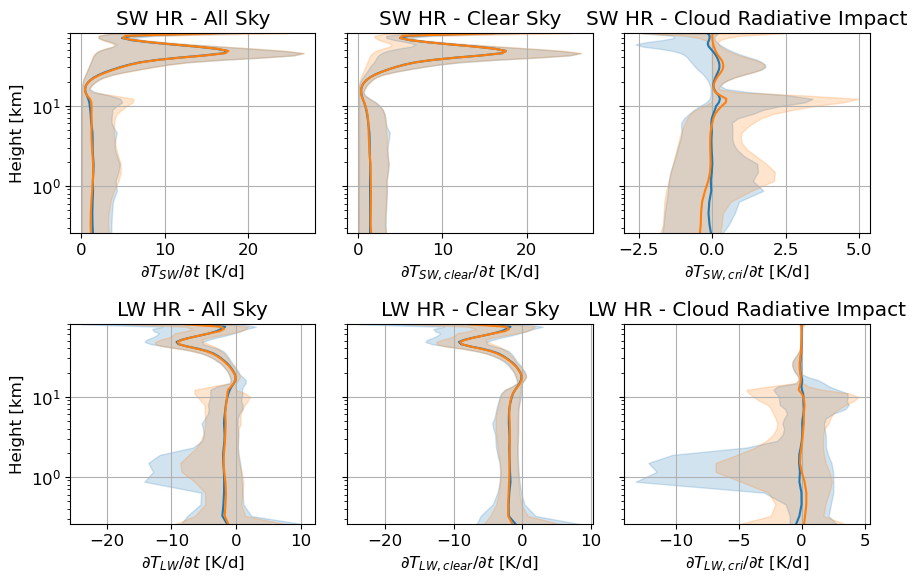

In [17]:
fig, axs = plt.subplots(2, 3, figsize=(9, 6))

ax_sw = plot_3d_full_level(statistics_cs["tend_ta_rsw"], statistics["corrected_tend_ta_rsw"], v="tend_ta_rsw", height_label = True, ax=axs[0,0])
ax_sw_cs = plot_3d_full_level(statistics_cs["tend_ta_rsw_cs"], statistics["corrected_tend_ta_rsw_cs"], v="tend_ta_rsw_cs", ax=axs[0,1])
ax_sw_cre = plot_3d_full_level(statistics_cs["tend_ta_rsw_cre"], statistics["corrected_tend_ta_rsw_cre"], v="tend_ta_rsw_cre", ax=axs[0,2])

ax_lw = plot_3d_full_level(statistics_cs["tend_ta_rlw"], statistics["corrected_tend_ta_rlw"], v="tend_ta_rlw", height_label = True, ax=axs[1,0])
ax_lw_cs = plot_3d_full_level(statistics_cs["tend_ta_rlw_cs"], statistics["corrected_tend_ta_rlw_cs"], v="tend_ta_rlw_cs", ax=axs[1,1])
ax_lw_cre = plot_3d_full_level(statistics_cs["tend_ta_rlw_cre"], statistics["corrected_tend_ta_rlw_cre"], v="tend_ta_rlw_cre", ax=axs[1,2])

plt.tight_layout()
plt.savefig("output.pdf")
plt.show()

tend_ta_rsw mean diff:  -1.9937260415430775 abs mean diff:  1.9937260415430775 min diff:  0.11292519271042224 max diff:  10.074633806822112
bottom 23 levels  14.741908 tend_ta_rsw mean diff:  -0.4514736865929039 abs mean diff:  0.4514736865929039 min diff:  0.11292519271042224 max diff:  0.7240106555994638
tend_ta_rsw_cs mean diff:  -1.9294355103342389 abs mean diff:  1.9294355103342389 min diff:  0.13365918154246795 max diff:  9.923393920977697
bottom 23 levels  14.741908 tend_ta_rsw_cs mean diff:  -0.49231375731752475 abs mean diff:  0.49231375731752475 min diff:  0.13365918154246795 max diff:  0.7175215364233712
tend_ta_rsw_cre mean diff:  -0.06484200690118429 abs mean diff:  0.17895325598909764 min diff:  0.0088995638186889 max diff:  0.5078254998284173
bottom 23 levels  14.741908 tend_ta_rsw_cre mean diff:  0.03971312905698469 abs mean diff:  0.19347072777483817 min diff:  0.01617153624412942 max diff:  0.5078254998284173
tend_ta_rlw mean diff:  1.1454308735990544 abs mean diff:  

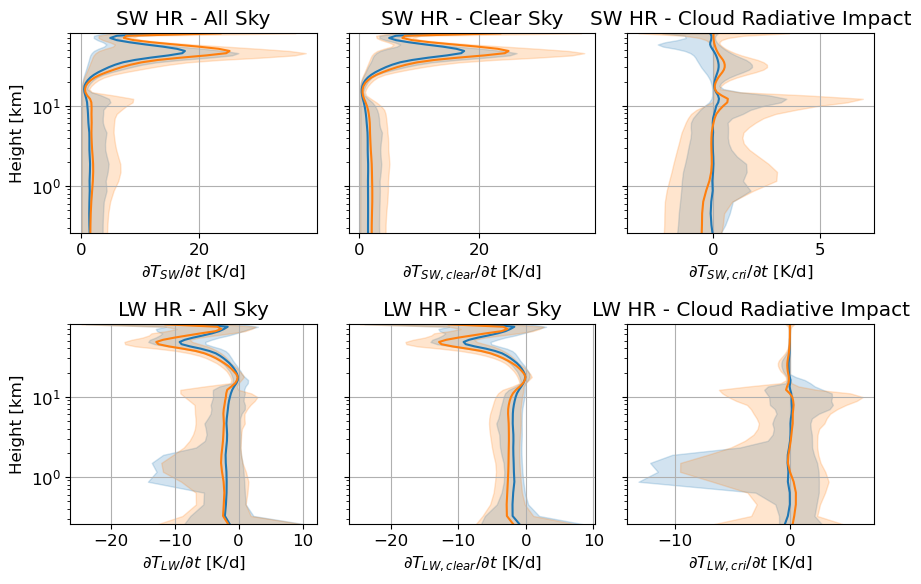

In [64]:
fig, axs = plt.subplots(2, 3, figsize=(9, 6))

ax_sw = plot_3d_full_level(statistics_cs["tend_ta_rsw"], statistics["tend_ta_rsw"], v="tend_ta_rsw", height_label = True, ax=axs[0,0])
ax_sw_cs = plot_3d_full_level(statistics_cs["tend_ta_rsw_cs"], statistics["tend_ta_rsw_cs"], v="tend_ta_rsw_cs", ax=axs[0,1])
ax_sw_cre = plot_3d_full_level(statistics_cs["tend_ta_rsw_cre"], statistics["tend_ta_rsw_cre"], v="tend_ta_rsw_cre", ax=axs[0,2])

ax_lw = plot_3d_full_level(statistics_cs["tend_ta_rlw"], statistics["tend_ta_rlw"], v="tend_ta_rlw", height_label = True, ax=axs[1,0])
ax_lw_cs = plot_3d_full_level(statistics_cs["tend_ta_rlw_cs"], statistics["tend_ta_rlw_cs"], v="tend_ta_rlw_cs", ax=axs[1,1])
ax_lw_cre = plot_3d_full_level(statistics_cs["tend_ta_rlw_cre"], statistics["tend_ta_rlw_cre"], v="tend_ta_rlw_cre", ax=axs[1,2])

plt.tight_layout()
plt.savefig("output.pdf")
plt.show()

extra_3d_hus mean diff:  -0.15718269588547001 abs mean diff:  0.15994488049704766 min diff:  1.5250332941478306e-06 max diff:  1.3031720974772243
bottom 46 levels  74.65977 extra_3d_hus mean diff:  -0.16061208253533432 abs mean diff:  0.1634095715946294 min diff:  1.5250332941478306e-06 max diff:  1.3031720974772243
extra_3d_clw mean diff:  -0.0012512867333820384 abs mean diff:  0.0015181210394143848 min diff:  0.0 max diff:  0.010925508852402165
bottom 46 levels  74.65977 extra_3d_clw mean diff:  -0.0012784886188903436 abs mean diff:  0.001551123670706002 min diff:  0.0 max diff:  0.010925508852402165
extra_3d_cli mean diff:  0.0015107831860664321 abs mean diff:  0.0015121505698609732 min diff:  0.0 max diff:  0.0070033700232072634
bottom 46 levels  74.65977 extra_3d_cli mean diff:  0.001543626298807007 abs mean diff:  0.0015450234083362116 min diff:  0.0 max diff:  0.0070033700232072634
cl mean diff:  -0.5345701689558415 abs mean diff:  1.542607512550893 min diff:  0.0 max diff:  7.3

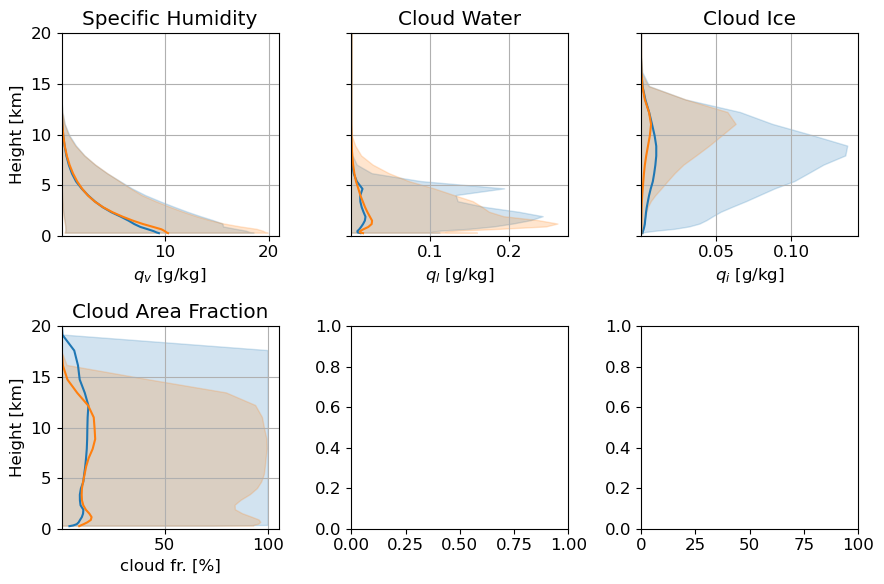

In [19]:
fig, axs = plt.subplots(2, 3, figsize=(9, 6))

plot_3d_full_level(statistics_cs["extra_3d_hus"], statistics["extra_3d_hus"], v="extra_3d_hus", height_label = True, ax=axs[0,0])
plot_3d_full_level(statistics_cs["extra_3d_clw"], statistics["extra_3d_clw"], v="extra_3d_clw", ax=axs[0,1])
plot_3d_full_level(statistics_cs["extra_3d_cli"], statistics["extra_3d_cli"], v="extra_3d_cli", ax=axs[0,2])

plot_3d_full_level(statistics_cs["cl"], statistics["cl"], v="cl", height_label = True, ax=axs[1,0])
#plot_3d_full_level(statistics_cs["tend_ta_rlw_cs"], statistics["corrected_tend_ta_rlw_cs"], v="tend_ta_rlw_cs", ax=axs[1,1])
#plot_3d_full_level(None, statistics["extra_3d_qs"], v="extra_3d_qs", ax=axs[1,2])

plt.tight_layout()
plt.savefig("input.png")
plt.show()

In [43]:
statistics.keys()

dict_keys(['cell_idx', 'cl', 'clt', 'cvair', 'dzghalf', 'extra_2d_albedo', 'extra_2d_iwp', 'extra_2d_lwp', 'extra_2d_pr', 'extra_2d_prw', 'extra_3d_cli', 'extra_3d_clw', 'extra_3d_hus', 'extra_3d_qs', 'extra_3d_ta', 'o3', 'pr', 'pr_grpl', 'pr_ice', 'pr_rain', 'pr_snow', 'pres_layer', 'pres_level', 'ps', 'rho', 'rld', 'rldcs', 'rlds_rld', 'rlu', 'rlucs', 'rlut', 'temp_level', 'tend_ta_rlw', 'tend_ta_rlw_cs', 'ts', 'ts_rad', 'zfull', 'zhalf', 'tend_ta_rlw_cre', 'albnirdif', 'albnirdir', 'albvisdif', 'albvisdir', 'cosmu0', 'cosmu0_rt', 'rnds_dif', 'rnds_dir', 'rpds_dif', 'rpds_dir', 'rsds', 'rsut', 'rvds_dif', 'rvds_dir', 'tend_ta_rsw', 'tend_ta_rsw_cs', 'toa', 'rsu', 'rsucs', 'rsd', 'rsdcs', 'tend_ta_rsw_cre', 'corrected_tend_ta_rlw', 'corrected_tend_ta_rlw_cs', 'corrected_tend_ta_rlw_cre', 'corrected_tend_ta_rsw', 'corrected_tend_ta_rsw_cs', 'corrected_tend_ta_rsw_cre'])

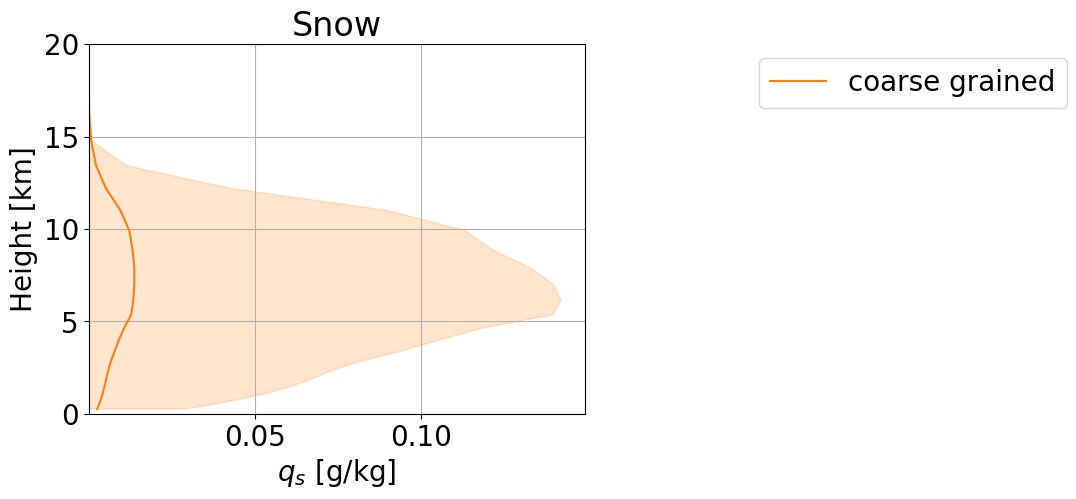

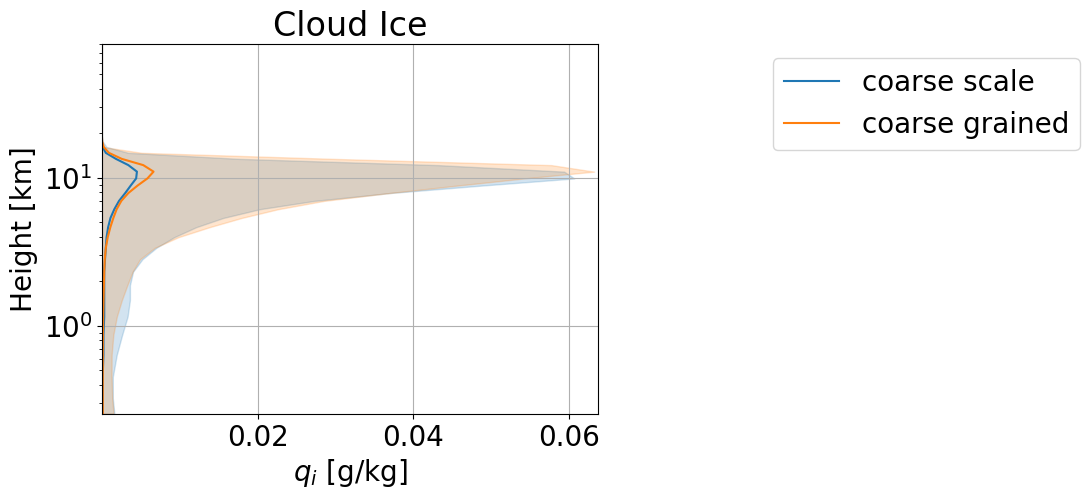

In [21]:
v = "extra_3d_qs"
sd2 = statistics[v]
f = 1000

plt.title(title_translate[v])
plt.fill_betweenx(height, f*sd2[min_stat], f*sd2[max_stat], alpha=0.2, color = c_cg)
plt.plot(f*sd2["mean"], height, label = "coarse grained", color = c_cg)
plt.ylabel("Height [km]")
plt.xlabel(label_translate[v])
plt.legend(bbox_to_anchor=(2, 1))
if v in ["extra_3d_hus", "extra_3d_cli", "extra_3d_clw", "extra_3d_qs", "rho"]:
    #plt.xscale("log")
    #plt.yscale("log")
    plt.legend(bbox_to_anchor=(2, 1))
    plt.xlim(1e-7, f*np.max(sd2[max_stat])*1.05)
if v in ["cl"] or "tend_ta" in v:
    plt.yscale("log")
plt.ylim((0, 20))
plt.grid()
plt.show()
plt.close()

v = "extra_3d_cli"
sd1 = statistics_cs[v]
sd2 = statistics[v]
sd3 = statistics["extra_3d_qs"]
f = 1000
max_stat="p97.5"

plt.title(title_translate[v])
plt.fill_betweenx(height, f*sd1[min_stat], f*sd1[max_stat], alpha=0.2, color = c_cs)
plt.plot(f*sd1["mean"], height, label="coarse scale", color = c_cs)
plt.fill_betweenx(height, f*sd2[min_stat], f*sd2[max_stat], alpha=0.2, color = c_cg)
plt.plot(f*sd2["mean"], height, label = "coarse grained", color = c_cg)
#plt.fill_betweenx(height, f*sd3[min_stat], f*sd3[max_stat], alpha=0.2, color = "C4")
#plt.plot(f*sd3["mean"], height, label = "coarse grained-snow", color = "C4")
#plt.fill_betweenx(height, f*sd2[min_stat]+f*sd3[min_stat], f*sd2[max_stat]+f*sd3[max_stat], alpha=0.2, color = "C3")
#plt.plot(f*sd2["mean"]+f*sd3["mean"], height, label = "coarse grained + snow", color = "C3")
plt.ylabel("Height [km]")
plt.xlabel(label_translate[v])
plt.legend(bbox_to_anchor=(2, 1))
if v in ["extra_3d_hus", "extra_3d_cli", "extra_3d_clw", "extra_3d_qs", "rho"]:
    #plt.xscale("log")
    plt.yscale("log")
    plt.legend(bbox_to_anchor=(2, 1))
    plt.xlim(1e-7, np.max(sd1[max_stat])*f*1.05)
if v in ["cl"] or "tend_ta" in v:
    plt.yscale("log")
plt.ylim((np.min(height), np.max(height)))
plt.grid()
plt.show()
plt.close()

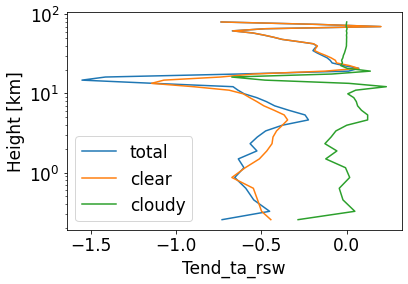

In [26]:
f = 86400
sd1 = statistics_cs["tend_ta_rlw"]
sd2 = statistics["tend_ta_rlw"]

sd3 = statistics_cs["tend_ta_rlw_cs"]
sd4 = statistics["tend_ta_rlw_cs"]

a = (sd1["mean"]-sd2["mean"])/sd1["mean"]
b = (sd3["mean"]-sd4["mean"])/sd3["mean"]
plt.plot(a, height, label="total", color = "C0")
plt.plot(b, height, label="clear", color = "C1")
plt.plot(a-b, height, label="cloudy", color = "C2")
#plt.plot((sd1["mean"]-sd3["mean"]-(sd2["mean"]-sd4["mean"]))/(sd1["mean"]-sd3["mean"]), height, label="cloudy", color = "C2")
plt.ylabel("Height [km]")
plt.yscale("log")
plt.xlabel("Tend_ta_rsw")
plt.legend()
plt.show()
plt.close()

In [15]:
statistics.keys()


dict_keys(['cl', 'clt', 'cvair', 'extra_2d_albedo', 'extra_2d_iwp', 'extra_2d_lwp', 'extra_2d_prw', 'extra_3d_cli', 'extra_3d_clw', 'extra_3d_hus', 'extra_3d_qs', 'extra_3d_ta', 'o3', 'rho', 'rlds_rld', 'rlut', 'tend_ta_rlw', 'tend_ta_rlw_cs', 'ts', 'ts_rad', 'albnirdif', 'albnirdir', 'albvisdif', 'albvisdir', 'cosmu0', 'cosmu0_rt', 'rnds_dif', 'rnds_dir', 'rpds_dif', 'rpds_dir', 'rsds', 'rsut', 'rvds_dif', 'rvds_dir', 'tend_ta_rsw', 'tend_ta_rsw_cs', 'toa'])